# A tale of two time scales: Determining integrated volatility with noisy high-frequency data
## Numerical simulation

## Libraries importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## The Model 

We choose the Black-Scholes Model : $S_t = S_0 exp((- \frac{\sigma^2}{2})t + \sigma B_t) \Longleftrightarrow dX_t = \sigma dB_t \ with \ X_t = ln(S_t)$

$X_t$ is an Ito Process.

In [2]:
def brownian_motion(n, m = 1000, T = 1):
    '''
        n: number of time steps
        m: number of trajectories
        T: final time
        returns: B (m x n+1) matrix of Brownian motion
    '''
   
    B = np.zeros((m, n+1))
    dt = T/n

    dB = np.sqrt(dt) * np.random.randn(m, n)
    B[:, 1:] = np.cumsum(dB, axis=1)
    return B

def black_scholes(S0, mu, sigma, T, n, m = 1000):
    '''
        S0: initial stock price
        mu: drift
        sigma: volatility
        T: final time
        n: number of time steps
        m: number of trajectories
        returns: S (m x n+1) matrix of stock prices
    '''
    S = np.zeros((m, n+1))
    B = brownian_motion(n, m, T)

    times = np.linspace(0, T, n+1)
    S = S0 * np.exp((mu - 0.5 * sigma*sigma) * times + sigma * B)

    return S

def observed_prices(S0, mu, sigma, T, n, m = 1000, noise = 0.1):
    '''
        S0: initial stock price
        mu: drift
        sigma: volatility
        T: final time
        n: number of time steps
        m: number of trajectories
        noise: standard deviation of the noise

        returns: S (m x n+1) matrix of observed stock prices
    '''
    S = black_scholes(S0, mu, sigma, T, n, m)
    return np.log(S) + noise * np.random.randn(m, n+1)

## Part 1: Monte-Carlo Estimators

> ### First estimator: $[Y,Y]_T^{(all)}$

In [ ]:
# First estimator of the volatility : the realized volatility
def realized_volatility(S):
    '''
        S: (m x n+1) matrix of stock prices
        returns: (m,) vector of realized volatilities
    '''
    return np.sum(np.diff(S, axis=1)**2, axis=1)


> ### Second estimator: $[Y,Y]_T^{(sparse)}$

In [4]:
def sparse_volatility(S, noise, sigma, T, n, complete = False):
    '''
        S: (m x n+1) matrix of stock prices
        noise: standard deviation of the noise
        sigma: volatility
        T: final time
        n: number of time steps

        returns: (m,) vector of sparse volatilities, n_sparse
    '''

    # n_sparse optimal
    n_sparse = int(((sigma**4 * T**2) / (4 * noise**4))**(1/3))
    
    # Ensure n_sparse is at least 1 to avoid division by zero
    n_sparse = max(1, n_sparse)
    # Sparse grid
    step = max(int(n / n_sparse), 1)
    S_sparse = S[:, ::step]  # (m x n_sparse+1) matrix of stock prices
    
    if complete:
        return realized_volatility(S_sparse), n_sparse
    else:
        return realized_volatility(S_sparse)

> ### Third estimator: $[Y,Y]_T^{(avg)}$

In [18]:
# Third estimator of the volatility: [Y,Y]avg : average of the sparse volatility in order to use all the data

def avg_sparse_volatility(S, noise, sigma, T, n, complete=False):
    '''
        S: (m x n+1) matrix of stock prices
        noise: standard deviation of the noise
        sigma: volatility
        T: final time
        n: number of time steps

        returns: (m,) vector of average sparse volatilities
    '''
    # Optimal sparse frequency (n_opt) and number of grids (K)
    n_opt = ((sigma**4 * T**2) / (6 * noise**4))**(1/3)
    K = max(int(n // n_opt), 1)  # Ensures we have an integer K

    # Calculate realized volatility on each sparse sample and average
    sparse_volatilities = np.zeros((K, S.shape[0]))
    for i in range(K):
        # Take every K-th point starting from i for each grid
        S_sparse = S[:, i::K]
        sparse_volatilities[i] = realized_volatility(S_sparse)

    # Final averaging step
    avg_sparse_vol = np.mean(sparse_volatilities, axis=0)

    if complete:
        return avg_sparse_vol, n // K, K
    else:
        return avg_sparse_vol

> ### Final estimator: The two time scales estimator

In [14]:
def two_time_scales_volatility(S, noise, sigma, T, n):
    '''
        S: (m x n+1) matrix of stock prices
        noise: standard deviation of the noise
        sigma: volatility
        T: final time
        n: number of time steps

        returns: (m,) vector of two time scales volatilities
    '''
    # Optimal frequency for sparse sampling and number of sparse grids (K)
    n_sparse = ((sigma**4 * T**2) / (6 * noise**4))**(1/3)
    K = max(int(np.floor((2**(1/3) * n**(2/3)) / n_sparse)), 1)

    # Effective number of steps in each sparse grid
    n_bar = max(1, int(n / K))
    
    # Calculate realized volatility for each sparse sample
    sparse_volatilities = np.zeros((K, S.shape[0]))
    for i in range(K):
        # Sparse sampling: taking every K-th point starting from i
        S_sparse = S[:, i::K]
        sparse_volatilities[i] = realized_volatility(S_sparse)

    # Calculate the average of sparse volatilities
    avg_sparse_vol = np.mean(sparse_volatilities, axis=0)

    # Calculate realized volatility over the entire data set
    S_all = realized_volatility(S)

    # Compute the two time scales volatility
    result = avg_sparse_vol - ((n_bar-1) / n) * S_all

    return result


> ### Testing the estimators

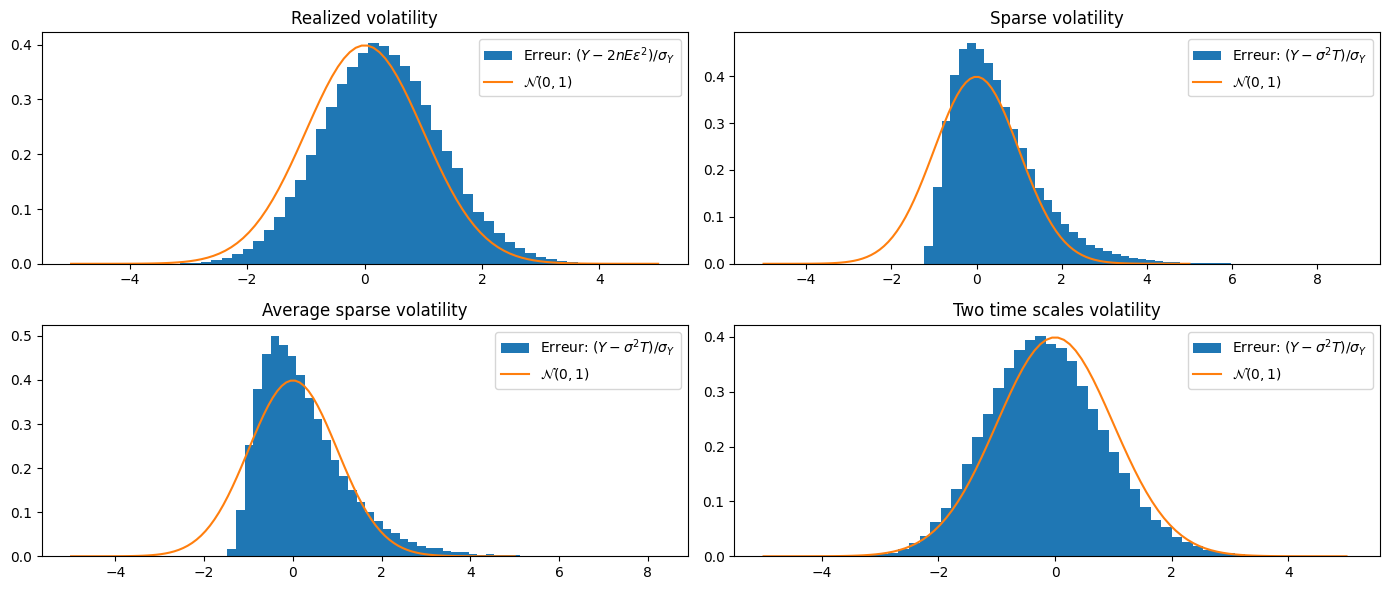

In [25]:
# Testing the estimators

# Parameters
S0 = 100
mu = 0
sigma = 0.2
T = 2
n = 1000
m = 100000
noise = 0.05

def gauss(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))

# Plot the histograms of estimators

S = observed_prices(S0, mu, sigma, T, n, m, noise)

def err(Y, sigma_=sigma, T_=T):
    return (Y/m - sigma_**2*T_)/Y.std()

Y1 = realized_volatility(S)
Y2, nsparse = sparse_volatility(S, noise, sigma, T, n, complete=True)
Y3, n_bar, K = avg_sparse_volatility(S, noise, sigma, T, n, complete=True)
Y4 = two_time_scales_volatility(S, noise, sigma, T, n)

plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
plt.hist( (Y1 - 2*n*noise**2)/Y1.std(), bins=50, density=True,  label='Erreur: $(Y - 2n E \epsilon^2)/\sigma_Y$')
x = np.linspace(-5, 5, 100)
plt.plot(x, gauss(x, 0, 1), label='$\mathcal{N}(0, 1)$')
plt.legend(loc='best')
plt.title('Realized volatility')

plt.subplot(2, 2, 2)
plt.hist((Y2 - sigma**2*T )/Y2.std(), bins=50, density=True, label='Erreur: $(Y - \sigma^2 T )/\sigma_Y$')
plt.plot(x, gauss(x, 0, 1), label='$\mathcal{N}(0, 1)$')
plt.legend(loc='best')
plt.title('Sparse volatility')

plt.subplot(2, 2, 3)
plt.hist((Y3 - sigma**2*T )/Y3.std(), bins=50, density=True, label='Erreur: $(Y - \sigma^2 T)/\sigma_Y$')
plt.plot(x, gauss(x, 0, 1), label='$\mathcal{N}(0, 1)$')
plt.legend(loc='best')
plt.title('Average sparse volatility')

plt.subplot(2, 2, 4)
plt.hist((Y4-sigma**2*T)/Y4.std(), bins=50, density=True, label='Erreur: $(Y - \sigma^2 T)/\sigma_Y$')
plt.plot(x, gauss(x, 0, 1), label='$\mathcal{N}(0, 1)$')
plt.legend(loc='best')
plt.title('Two time scales volatility')

plt.tight_layout()
plt.show()



## Part 2: Price trajectories

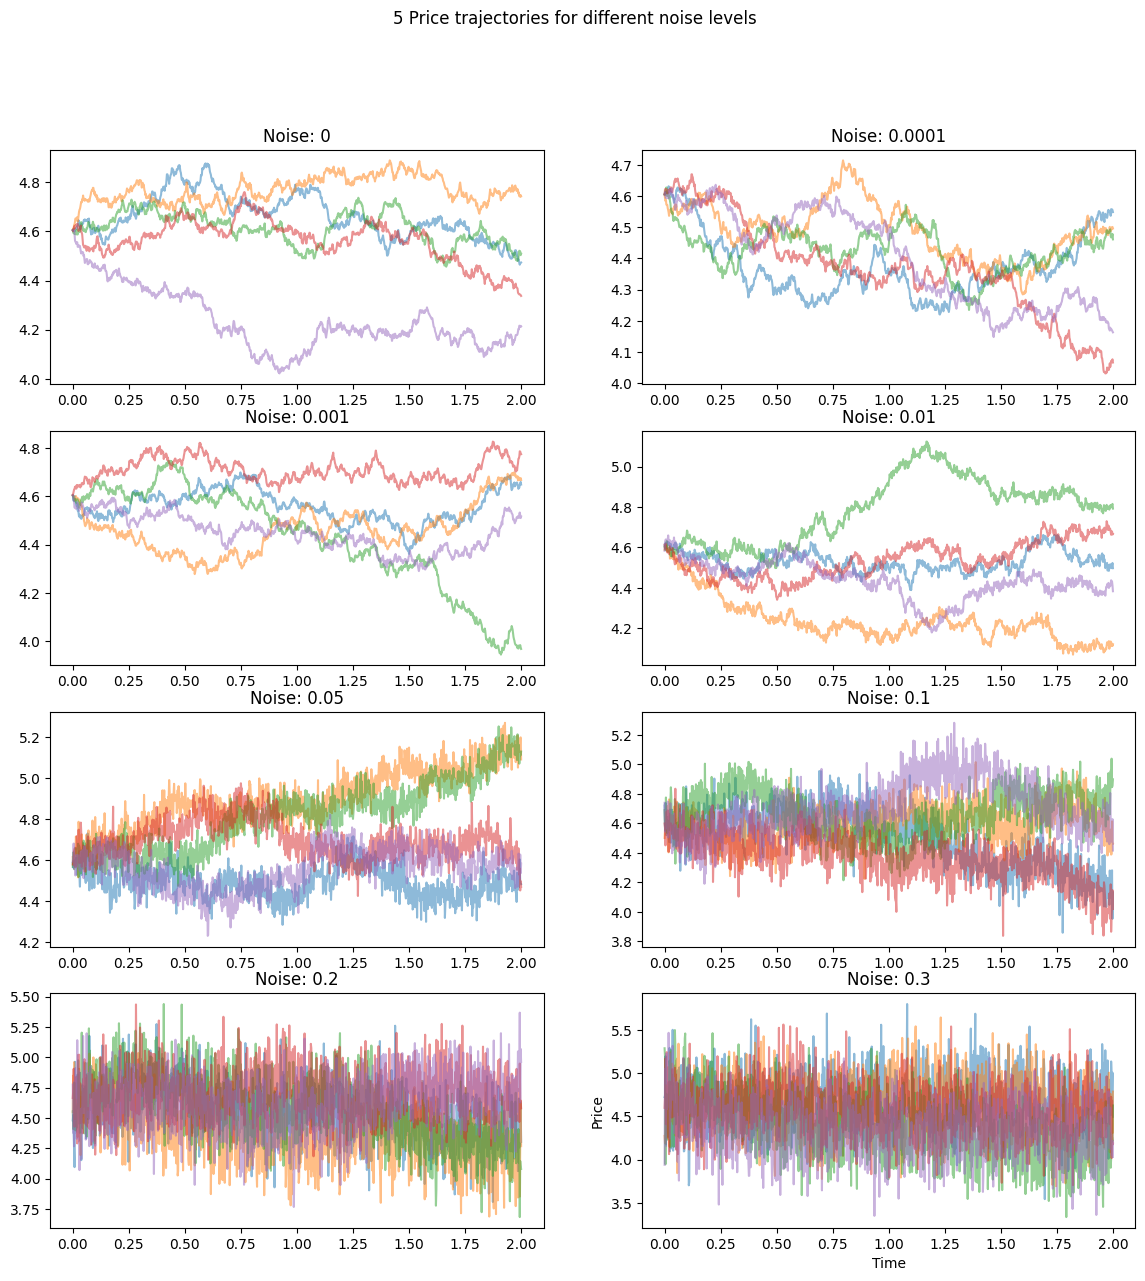

In [8]:
# 2nd task: Let's plot price trajectories by varying the noise

noises = [0, 0.0001,0.001,0.01, 0.05, 0.1, 0.2,0.3]
plt.figure(figsize=(14, 14))
for i, noise in enumerate(noises):
    plt.subplot(4, 2, i+1)
    S = observed_prices(S0, mu, sigma, T, n, 5, noise)
    plt.plot(np.linspace(0, T, n+1), S.T, alpha=0.5)
    plt.title('Noise: {}'.format(noise))

plt.suptitle('{} Price trajectories for different noise levels'.format(5))
plt.xlabel('Time')
plt.ylabel('Price')

plt.show()
